## Learn to use tensorflow object detection API
- [official repo](https://github.com/tensorflow/models/tree/master/research/object_detection)
- [TensorMouse](https://github.com/tadejmagajna/TensorMouse)

In [26]:
import cv2
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## load graph and make session

In [15]:
!ls ../../models/object_detection/ssd_mobilenet_v1_coco_11_06_2017/

frozen_inference_graph.pb  model.ckpt.data-00000-of-00001  model.ckpt.meta
graph.pbtxt		   model.ckpt.index


In [16]:
## load the frozen graph

def load_model(model_path):
    graph = tf.Graph()
    with graph.as_default():
        graph_def = tf.GraphDef()
        model_file = tf.gfile.GFile(model_path, "rb")
        graph_def.ParseFromString(model_file.read())
        tf.import_graph_def(graph_def, name="object_detection_api")
    return graph

model_path = "../../models/object_detection/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb"
model_graph = load_model(model_path)

In [94]:
## load label names - taking a shortcut
import re
def load_labels(label_path):
    id2label = {}
    
    with open(label_path, "r") as f:
        items = re.findall(r"item\s*\{[^}]*\}", f.read(), re.MULTILINE)
        for item in items:
            id = int(re.findall(r"id: (\d+)", item)[0])
            label = re.findall(r'display_name: "([\w\s]+)"', item)[0]
            id2label[id] = label
    return id2label

label_path = "../../models/object_detection/mscoco_label_map.pbtxt"
id2label = load_labels(label_path)

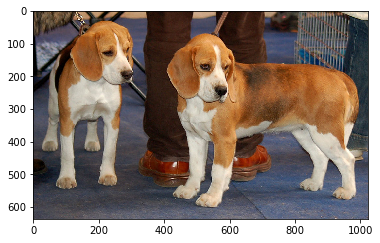

In [30]:
## test with an image

from urllib import request
from io import BytesIO
from PIL import Image

img_url = "https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image1.jpg"
img_bytes = BytesIO(request.urlopen(img_url).read())
img = np.array(Image.open(img_bytes, "r"))
plt.imshow(img)

In [95]:
with tf.Session(graph=model_graph) as sess:
    # restore placeholders and variables
    image = model_graph.get_tensor_by_name("object_detection_api/image_tensor:0")
    boxes = model_graph.get_tensor_by_name("object_detection_api/detection_boxes:0")
    scores = model_graph.get_tensor_by_name("object_detection_api/detection_scores:0")
    classes = model_graph.get_tensor_by_name("object_detection_api/detection_classes:0")
    
    # predictions
    pred_boxes, pred_scores, pred_classes = sess.run([boxes, scores, classes],
                                                     feed_dict={image: np.expand_dims(img, axis=0)})
    
pred_boxes = pred_boxes.squeeze()
pred_scores = pred_scores.squeeze()
pred_classes = pred_classes.squeeze()
pred_labels = np.array([id2label.get(c) for c in pred_classes])

In [97]:
pred_boxes.shape, pred_scores.shape, pred_labels.shape

((100, 4), (100,), (100,))

In [114]:
from matplotlib import patches

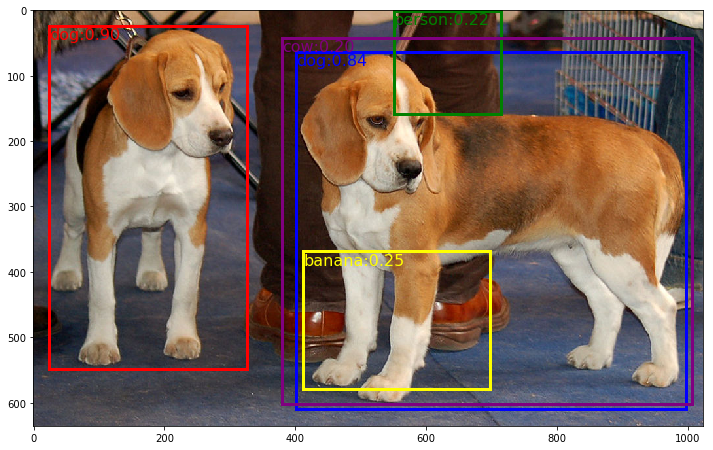

In [137]:
h, w = img.shape[:2]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(img)
colors = ["red", "blue", "yellow", "green", "purple"]
for i in range(5):
    box = pred_boxes[i]
    label = pred_labels[i]
    score = pred_scores[i]
    x0, y0 = box[1] * w, box[0] * h
    x1, y1 = box[3] * w, box[2] * h
    rw, rh = x1-x0, y1-y0
    ax.add_patch(patches.Rectangle([x0, y0], rw, rh, fill=False, color=colors[i], lw=3))
    ax.text(x0, y0+20, "%s:%.2f" % (label, score), color=colors[i], fontsize=16)